This activity is meant to extend your work with ARMA models to apply a forecasting model across stores in a retail chain, and items in each store. You will build models for each store for a specific item and compare this forecast to the model, aggregating all stores. Also, you will compare a model for sales by store for all items and discuss expected performance for each store according to your forecast.

In addition to the ARMA models, you will explore an extension of this to include seasonality elements with the SARIMA model. Both are implemented with statsmodels.

In [1]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data/train.csv.zip', compression = 'zip')

To begin, notice that the DataFrame df does not have a datetime index. Below, convert the date column to a datetime object and set it as the index to a new DataFrame called stores_df below.

In [3]:
stores_df = df
stores_df.set_index(pd.to_datetime(stores_df['date']))


,date,store,item,sales
date,,,,
2013-01-01,2013-01-01,1,1,13
2013-01-02,2013-01-02,1,1,11
2013-01-03,2013-01-03,1,1,14
2013-01-04,2013-01-04,1,1,13
2013-01-05,2013-01-05,1,1,10
...,...,...,...,...
2017-12-27,2017-12-27,10,50,63
2017-12-28,2017-12-28,10,50,59
2017-12-29,2017-12-29,10,50,74


In [4]:
stores_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In anticipation of building a 30-day forecast for sales of item 1 in store 1, subset the data to only the sales column for item 1 store 1 and assign as a DataFrame to store_1_item_1 below.

In [5]:
#store_1_item_1 = stores_df[(stores_df['store'] == 1) & (stores_df['item'] == 1)][['sales']]
store_1_item_1 = stores_df.query('item ==1 & store ==1')[['sales']]

Now, use the store 1 data from the previous question to create a train-test split where train_data is all but the last 30 days of sales data. You no longer need the store and item columns. Assign these values as X_train and X_test respectively.

In [6]:
X_train, X_test = store_1_item_1.iloc[:-30], store_1_item_1.iloc[-30:]

print(X_train.tail())
print(X_test.head())

      sales
1791     10
1792     14
1793     28
1794     15
1795     19
      sales
1796     16
1797     31
1798      7
1799     20
1800     17


Next, you will want to check the assumptions of our model before building it. Specifically, this was the notion that our time series is stationary for the ARMA models. Use the adfuller function to determine if the series is stationary. Assign the 
 value to pval below. Consider your threshold at p=0.01

In [7]:
result=adfuller(X_train)
pval=result[1]
print(f'The p-value is {pval: .4f}')

The p-value is  0.0266


Backing up the results of our hypothesis test, the autocorrelation of the original series seems to not be stationary. Instead, the differenced data and its ACF and PACF plots look better. We will begin by using these plots to suggest an order = (1, 0, 1) model based on the differenced data. Accordingly, build an ARIMA model with order = (1, 0, 1) and fit on the training data and assign to arma below.

Determine the mean squared error on the test data and assign it as a float to mse_test below.

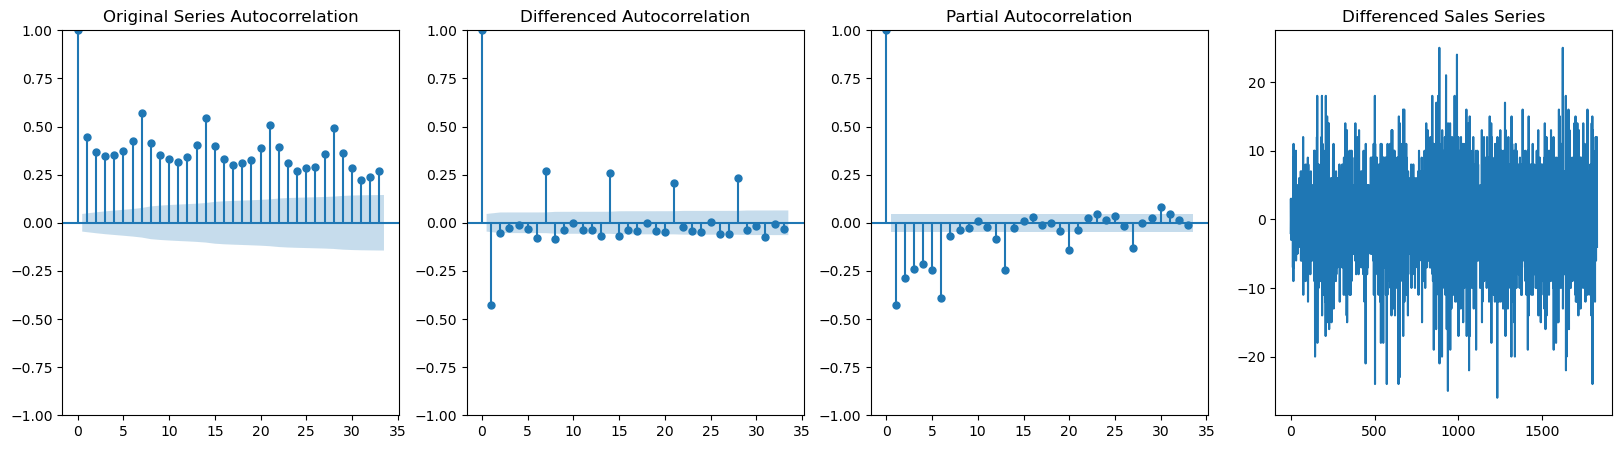

In [8]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
plot_acf(df[(df['store'] == 1) & (df['item'] == 1)]['sales'], ax = ax[0]);
ax[0].set_title('Original Series Autocorrelation')
plot_acf(df[(df['store'] == 1) & (df['item'] == 1)]['sales'].diff().dropna(), ax = ax[1]);
ax[1].set_title('Differenced Autocorrelation')
plot_pacf(df[(df['store'] == 1) & (df['item'] == 1)]['sales'].diff().dropna(), ax = ax[2], method = 'ywm');
ax[3].plot(df[(df['store'] == 1) & (df['item'] == 1)]['sales'].diff().dropna())
ax[3].set_title('Differenced Sales Series');

In [10]:
arma=ARIMA(X_train.diff(),order=(1,0,1)).fit()
preds=arma.forecast(len(X_test))
mse_test = mean_squared_error(preds,X_test)

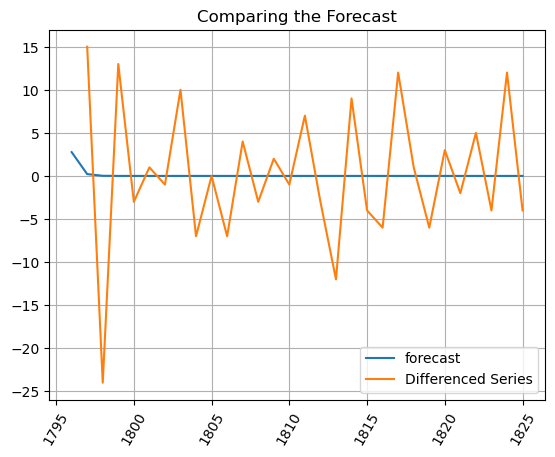

In [11]:
plt.plot(arma.forecast(steps = len(X_test)), label = 'forecast')
plt.plot(X_test.diff(), label = 'Differenced Series')
plt.title('Comparing the Forecast')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();

As discussed with the decomposition models earlier, there are ways to consider a seasonal oscillation within the data. For ARIMA, a version that adds in a seasonal element is called SARIMA. In statsmodels, we use the SARIMAX estimator to build this model that includes seasonal elements.

Much like the decomposition model, you can have a multiplicative or additive seasonality. For a multiplicative seasonal effect that we determine is yearly we add an argument

seasonal_order=(1, 1, 0, 12)
along with the order = (1, 0, 1). For more information see the user guide from statsmodels here.

Below, build a SARIMAX estimator with the above order and seasonality and fit on the training data. Assign the fit model to sarima below.

In [12]:
X_train, X_test = stores_df['sales'].iloc[-700:-30], stores_df.iloc[-30:]
sarima = SARIMAX(X_train,  order=(1, 0, 1), seasonal_order=(1, 1, 0, 12)).fit(disp=0)
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                  670
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood               -2863.003
Date:                             Wed, 03 Sep 2025   AIC                           5734.007
Time:                                     23:34:29   BIC                           5751.964
Sample:                                          0   HQIC                          5740.968
                                             - 670                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1281      0.167      0.769      0.442      -0.198       0.455
ma.L1          0.1222      0.172      0.712      0.476      -0.214       0.459
ar.S.L12      -0.4116      0.037    -10.992      0.000      -0.485      -0.338
sigma2       350.9937     19.375     18.116      0.000     313.020     388.967
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.53
Prob(Q):                              0.96   Prob(JB):                         0.06
Heteroskedasticity (H):               1.28   Skew:                             0.22
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

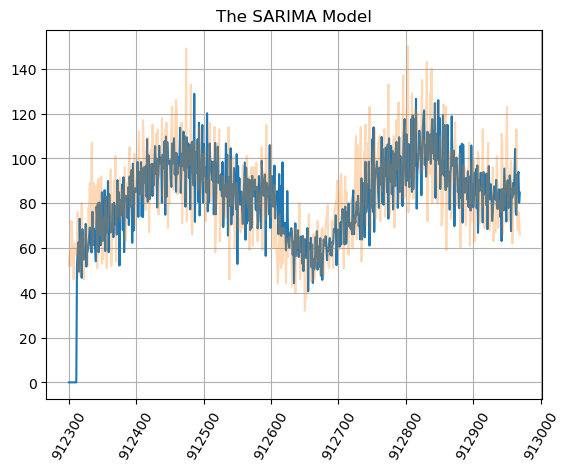

In [13]:
plt.plot(X_train.index, sarima.predict())
plt.plot(X_train.index, X_train, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The SARIMA Model')
plt.grid();

As you see, the SARIMA model can pick up the seasonal trends we have in this dataset. You can also get a more sensitive ARMA model by using higher-order terms. If you are interested in further work here, try grid-searching order and seasonality hyperparameters to determine the best model and order/seasonality parameters.

Also, you can incorporate other features about the data as exogenous elements of both the ARMA and SARIMA models in statsmodels. Consider trying engineering features with ts_fresh and using an exogenous model to see if this improves performance.